In [ ]:
from scipy.io import loadmat
import scipy.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import math
import os
import sklearn
from sklearn.utils import shuffle
import random
import tqdm
from tqdm import tqdm
import json
from tensorflow.keras.utils import plot_model
import pickle
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
!pip install tensorflow_addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 7.2 MB/s 


# Get Data

In [ ]:
def trip(img):
  return np.stack([img,img,img],-1)

def get_img(patient,day,n,eye=np.random.randint(0,2)):
  f_img = f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Normalized/{patient}/{day}.mat'
  img = loadmat(f_img)['data'][0,0][eye][0,0][1][n]

  return trip(img)

def get_label(patient,day,n,eye=np.random.randint(0,2)):
  f_ann = f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Original/{patient}/{day}/annotation.txt'
  with open(f_ann, 'r') as f: x,y,z = map(float,f.readlines()[n].split()[26:29])
  norm = np.linalg.norm([x,y,z])
  x /= norm
  y /= norm
  z /= norm

  theta = math.asin(-y)*180./np.pi
  phi = math.atan2(-x,-z)*180./np.pi

  return np.array([theta, phi])

def get_data(patient,day,n,eye=np.random.randint(0,2)):
  img = get_img(patient,day,n,eye)
  label = get_label(patient,day,n,eye)

  return img, label

def get_day(patient,day):
  f_img = f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Normalized/{patient}/{day}.mat'
  data = loadmat(f_img)['data']

  f_ann = f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Original/{patient}/{day}/annotation.txt'
  lines = []
  with open(f_ann, 'r') as f: lines = f.readlines()
  labels = []
  lms = []
  for line in lines:
    anns = list(map(float,line.split()))
    x,y,z = anns[26:29]
    norm = np.linalg.norm([x,y,z])
    x /= norm
    y /= norm
    z /= norm

    theta = math.asin(-y)*180./np.pi
    if theta < 0: theta += 360.
    phi = math.atan2(-x,-z)*180./np.pi
    if phi < 0: phi += 360.
    labels.append(np.array([theta,phi]))

    lm = anns[0:24]+anns[29:]
    lms.append(np.array(lm))

  size = len(labels)

  imgs0 = []
  imgs1 = []

  for i in range(size):
    imgs0.append(trip(data[0,0][0][0,0][1][i][:,::-1]))
    imgs1.append(trip(data[0,0][1][0,0][1][i]))

  return imgs0, imgs1, lms, labels

def get_patient(patient):
  days = [day.replace('.mat','') for day in os.listdir(f'/content/drive/MyDrive/MPII/MPIIGaze/Data/Normalized/{patient}') if '.mat' in day]
  imgs0 = []
  imgs1 = []
  lms = []
  labels = []
  for day in days:
    dimg0, dimg1, dlm, dlabel = get_day(patient,day)
    imgs0.extend(dimg0)
    imgs1.extend(dimg1)
    lms.extend(dlm)
    labels.extend(dlabel)
  return imgs0, imgs1, lms, labels

def get_dataset(patients):
  x0 = []
  x1 = []
  x2 = []
  y = []
  for patient in tqdm(patients):
    imgs0, imgs1, lms, labels = get_patient(patient)
    x0.extend(imgs0)
    x1.extend(imgs1)
    x2.extend(lms)
    y.extend(labels)
  x0,x1,x2,y = shuffle(x0,x1,x2,y,random_state=42)
  return [np.array(x0),np.array(x1),np.array(x2)], np.array(y)

In [ ]:
patients = [p for p in os.listdir('/content/drive/MyDrive/MPII/MPIIGaze/Data/Normalized')]

In [ ]:
random.Random(32).shuffle(patients)

In [ ]:
train_patients = patients[:11]
val_patients = patients[11:13]
test_patients = patients[13:]

In [ ]:
x_train, y_train = get_dataset(train_patients)

100%|██████████| 11/11 [09:09<00:00, 49.94s/it]


In [ ]:
x_val, y_val = get_dataset(val_patients)

100%|██████████| 2/2 [05:44<00:00, 172.45s/it]


In [ ]:
x_test, y_test = get_dataset(test_patients)

100%|██████████| 2/2 [04:45<00:00, 142.70s/it]


In [ ]:
def savedata(x,f):
  with open(f'/content/drive/MyDrive/MPII/MPIIGaze/{f}.pkl','wb') as file:
    pickle.dump(x,file)

def loaddata(f):
  with open(f'/content/drive/MyDrive/MPII/MPIIGaze/{f}.pkl','rb') as file:
    return pickle.load(file)
  print("ERROR, FILE NOT OPENED")
  return None

In [ ]:
savedata(x_train,"x_train")

In [ ]:
savedata(x_val,"x_val")

In [ ]:
savedata(x_test,"x_test")

In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/y_train.npy', y_train)

In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/y_val.npy', y_val)

In [ ]:
np.save('/content/drive/MyDrive/MPII/MPIIGaze/y_test.npy', y_test)

In [ ]:
x_train = loaddata('x_train')
x_val = loaddata('x_val')
x_test = loaddata('x_test')

y_train = np.load('/content/drive/MyDrive/MPII/MPIIGaze/y_train.npy')
y_val = np.load('/content/drive/MyDrive/MPII/MPIIGaze/y_val.npy')
y_test = np.load('/content/drive/MyDrive/MPII/MPIIGaze/y_test.npy')

# Make CCT

In [ ]:
!pip install -U -q tensorflow-addons
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 16
num_epochs = 50
image_size = (36,60)

num_outs = 512
input_shape = (36, 60, 3)

class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size[0], image_size[1], 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Note the rescaling layer. These layers have pre-defined inference behavior.
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255)
    ],
    name="data_augmentation",
)

def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_outs, activation='relu')(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Make Model

In [ ]:
num_classes = 2
lm_shape = 36
eye_shape = [36, 60, 3]

batch_size = 256
num_epochs = 200

def conv_block(inputs,n,filter_size,kernel_size,strides):
  conv = keras.layers.Conv2D(filter_size, kernel_size=kernel_size, strides=strides, name=f"conv{n}")(inputs)
  batchnorm = keras.layers.BatchNormalization(momentum=0.9,name=f"batchnorm{n}")(conv)
  leakyrelu = keras.layers.LeakyReLU(alpha=1e-2,name=f"leakyrelu{n}")(batchnorm)
  avgpool = keras.layers.AveragePooling2D(pool_size=2,strides=1,name=f"avgpool{n}")(leakyrelu)
  dropout = keras.layers.Dropout(0.02,name=f"dropout{n}")(avgpool)
  return dropout

def linear_block(inputs,n,units):
  linear = layers.Dense(units,name=f"linear{n}")(inputs)
  batchnorm = layers.BatchNormalization(momentum=0.9,name=f"batchnorm{n}")(linear)
  relu = layers.ReLU(name=f"relu{n}")(batchnorm)
  return relu

def create_eye_model(n=512):
  # inputs = layers.Input(eye_shape)

  # conv_block_1 = conv_block(inputs,1,32,7,2)
  # conv_block_2 = conv_block(conv_block_1,2,64,5,2)
  # conv_block_3 = conv_block(conv_block_2,3,128,3,1)
  # flatten = layers.Flatten(name='flatten')(conv_block_3)

  # return keras.models.Model(inputs,flatten)

  # resnet = keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=eye_shape)
  # global_avg = keras.layers.GlobalAveragePooling2D()(resnet.output)
  # outs = keras.layers.Dense(512, activation='relu')(global_avg)
  return create_cct_model()

def create_lm_model():
  inputs = layers.Input(lm_shape)

  linear_block_1 = linear_block(inputs,1,128)
  linear_block_2 = linear_block(linear_block_1,2,16)
  linear_block_3 = linear_block(linear_block_2,3,16)

  return keras.models.Model(inputs,linear_block_3)

def create_cnn_model():
  eye0input = layers.Input(eye_shape)
  eye1input = layers.Input(eye_shape)
  # lminput = layers.Input(lm_shape)

  eyemodel = create_eye_model()
  # lmmodel = create_lm_model()

  eye0feats = eyemodel(eye0input)
  eye1feats = eyemodel(eye1input)
  # lmfeats = lmmodel(lminput)

  concat = layers.Concatenate()([eye0feats,eye1feats])

  dense1 = layers.Dense(1000, activation='relu')(concat)
  # batchnorm1 = layers.BatchNormalization(momentum=0.9)(dense1)
  # dropout1 = layers.Dropout(0.12)(batchnorm1)
  # relu1 = layers.ReLU()(dropout1)

  # dense2 = layers.Dense(4)(relu1)
  # batchnorm2 = layers.BatchNormalization(momentum=0.9)(dense2)
  # relu2 = layers.ReLU()(batchnorm2)

  # outs = layers.Dense(2,activation='relu')(relu2)
  outs = layers.Dense(2,activation='relu')(dense1)

  model = keras.models.Model(inputs=[eye0input,eye1input],outputs=outs)
  return model

def run_experiment(model,name):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=[
            'mse'
        ],
    )

    checkpoint_filepath = f"/content/drive/MyDrive/MPII/MPIIGaze/{name}_model_weights.hdf5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=[x_train[0], x_train[1]],
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=([x_val[0], x_val[1]], y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    return model, history

In [ ]:
cct_model = create_cnn_model()

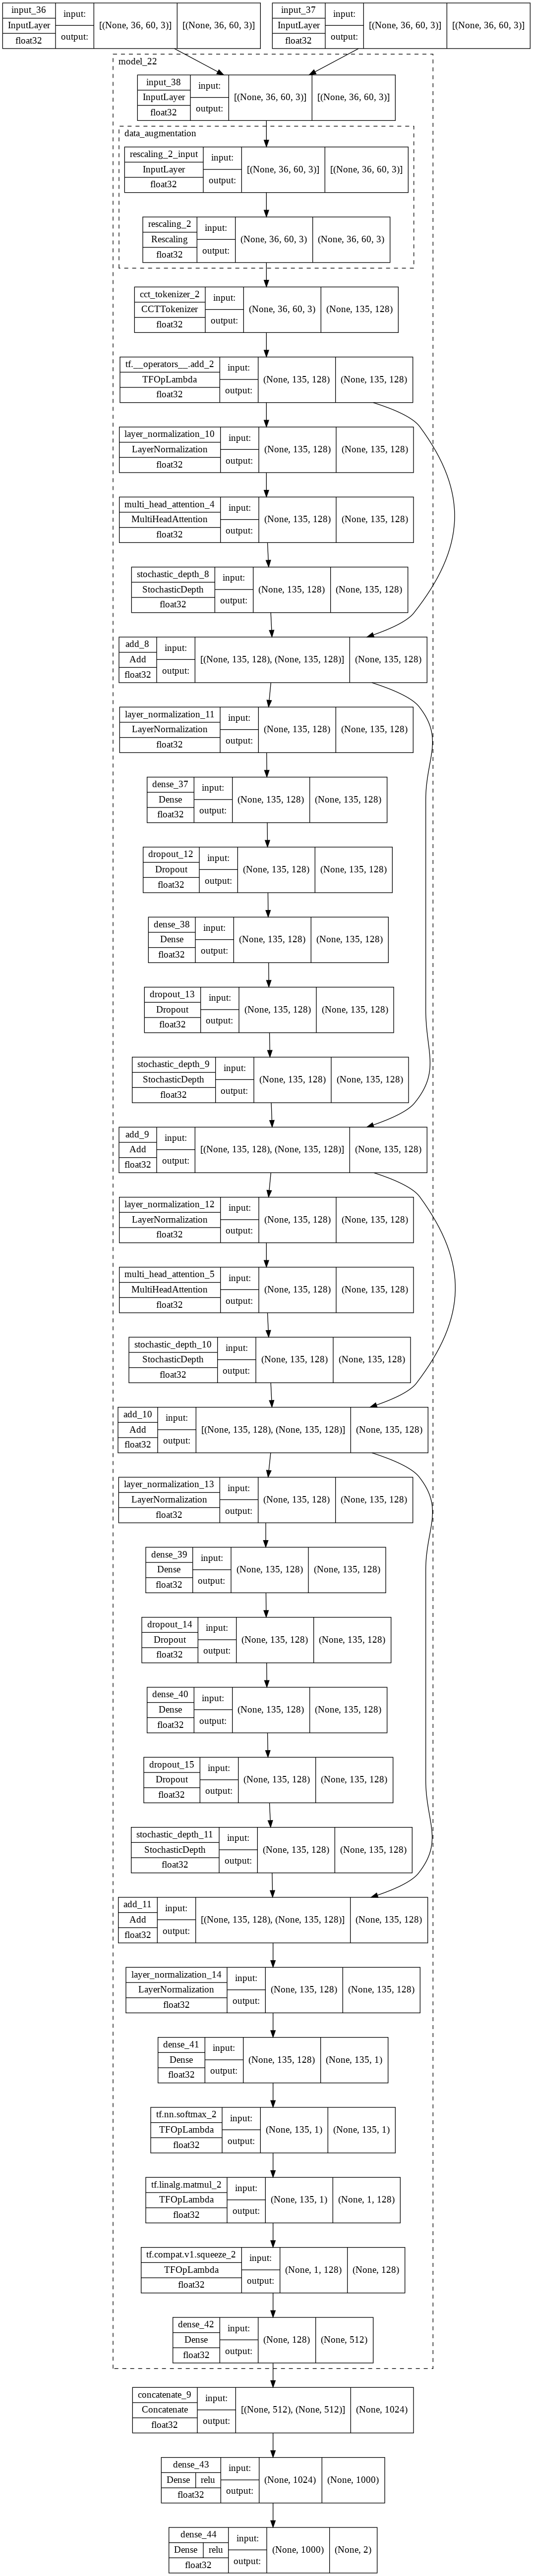

In [ ]:
plot_model(cct_model,show_shapes=True,show_dtype=True,show_layer_names=True,expand_nested=True,show_layer_activations=True)

In [ ]:
cct_model, cct_history = run_experiment(cct_model,"cct")
json.dump(cct_history.history, open('/content/drive/MyDrive/MPII/MPIIGaze/cct_model.json','w'))

Epoch 1/200
607/607 [==============================] - 155s 185ms/step - loss: 5656.8491 - mse: 5656.8491 - val_loss: 3840.5747 - val_mse: 3840.5747
Epoch 2/200
607/607 [==============================] - 110s 182ms/step - loss: 3254.0300 - mse: 3254.0300 - val_loss: 2684.5669 - val_mse: 2684.5669
Epoch 3/200
607/607 [==============================] - 111s 182ms/step - loss: 2367.7488 - mse: 2367.7488 - val_loss: 2447.2144 - val_mse: 2447.2144
Epoch 4/200
607/607 [==============================] - 111s 183ms/step - loss: 2209.2791 - mse: 2209.2791 - val_loss: 2311.7324 - val_mse: 2311.7324
Epoch 5/200
607/607 [==============================] - 111s 183ms/step - loss: 2118.4067 - mse: 2118.4067 - val_loss: 2161.4951 - val_mse: 2161.4951
Epoch 6/200
607/607 [==============================] - 111s 182ms/step - loss: 2049.0945 - mse: 2049.0945 - val_loss: 1924.1744 - val_mse: 1924.1744
Epoch 7/200
607/607 [==============================] - 110s 182ms/step - loss: 2010.0385 - mse: 2010.0385 

In [ ]:
print(cct_model.evaluate(x_test, y_test))

ValueError: ignored

In [ ]:
while True: pass